# KnapSack
The whole program is done using numpy operations as this allows for the program to run significantly faster in comparison to doing it all in python. Therefore, it was possible to run the algorithm with a lot of generations and big a population size, leading to a bit better results.

In [1863]:
import random
import copy

import numpy as np
import matplotlib.pyplot as plt

Loading of the file

In [1864]:
# loading of the file.
#input data price , weight
file_name = "input_1000.txt"

with open(file_name, "r") as file:
    first_line = file.readline().strip()
item_count, capacity = map(int, first_line.split())

data = np.loadtxt(file_name,skiprows=1,dtype=int)


Calculating how many items we should put into the backpack at the start. This is done by calculating average size of item and then putting into the backpack random items that if the weight of all of them was the average they would almost fully fill the backpack. It also helped when I intentionally put a little less (90% of the capacity) at the start as this allowed for the algorithm to add new items in the first mutations without going overweight. This helps the algorithm with much faster starts as if we only give each item 50% chance of being in the backpack and 50% to not be in it took around 300 generations only to get first valid results with the 1000 input. This also helps when we do not know how many items we will get and how big is our backpack.

In [1865]:
sum_price = np.sum(data[:,0])
sum_weight = np.sum(data[:,1])
average_weight = sum_weight /item_count
amount_of_ones = capacity / average_weight
ones_probability = (amount_of_ones/item_count)*0.90
def random_population(population_size, individual_size):
    population = np.random.choice([0, 1], size=(population_size, individual_size), replace=True, p=[1-ones_probability, ones_probability])
    return population

Fitness is the value of the items in the backpack and in a case that the backpack is overweight the fitness will - the amount we are over the limit. Even if two backpacks are overweight this promotes the oen that is lighter.

In [1866]:
def fitness(individual_coding):
    individual = np.matmul(individual_coding, data)
    weight = individual[1]
    if weight > capacity:
        return capacity-weight
    return individual[0]


In selection, we use tournament selection as this allows for us to also have negative fitness and elitism is used to store the 2 best individuals.

In [1867]:
def selection(population_,values):
    max1, max2 = 0,0
    idx1, idx2 = -1, -1
    for i, num in enumerate(values):
        if num > max1:
            max2, idx2 = max1, idx1
            max1, idx1 = num, i
        elif num > max2:
            max2, idx2 = num, i
    new_population = np.zeros_like(population_)
    new_population[0] = population_[idx1]
    new_population[1] = population_[idx2]
    for i in range(2,len(population_)):
        random_numbers = np.random.randint(0, len(population_), size=2)
        if values[random_numbers[0]] > values[random_numbers[1]]:
            new_population[i] = copy.deepcopy(population_[random_numbers[0]])
        else:
            new_population[i] = copy.deepcopy(population_[random_numbers[1]])
    return new_population


Just a simple one point crossover.

In [1868]:
def crossover(population_, crossover_prob=1):
    new_population = np.zeros_like(population_)
    for i in range(len(population_) // 2):
        individual1 = population_[2 * i]
        individual2 = population_[2 * i + 1]

        if random.random() < crossover_prob:
            crossover_point = random.randint(1, len(individual1) - 1)

            new_individual1 = np.concatenate([individual1[:crossover_point], individual2[crossover_point:]], axis=0)
            new_individual2 = np.concatenate([individual2[:crossover_point], individual1[crossover_point:]], axis=0)

        else:
            new_individual1 = individual1
            new_individual2 = individual2

        new_population[2 * i]=new_individual1
        new_population[2 * i + 1] =new_individual2

    return new_population

Simple mutation where the mutation probability is calculated to be on average 1 item in every individual. I experimented with decreasing mutation probability throughout the algorithm such that coming to the end of algorithm it got close to zero but that did not seem to help and made things only worse.

In [1869]:
def mutation(population_,mutation_probablity=0.1):
    new_population = np.zeros_like(population_)
    for i in range(len(population_)):
        individual = population_[i]
        individual = copy.deepcopy(individual)
        for j in range(len(individual)):
            if np.random.random() < mutation_probablity:
                individual[j] = 0 if individual[j] ==1 else 1
        new_population[i] =individual
    return new_population

I noticed that the mutation is one thing that takes the longest so I implemented the mutation fast which goes much faster and therefore alows me to train on much more generations of bigger size, but I always randomly choose whether I will mutate "mutations" slots and then generate random numbers at which position I mutate, this approach is on average around 30 times faster in the big example as I do not have to generate random number for each item in each individual. When having the algorithm run for the same time for both of those mutations this implementation
generated much better results.

In [1870]:
def mutation_fast(population_,mutations):
    new_population = np.zeros_like(population_)
    for i in range(len(population_)):
        individual = population_[i]
        individual = copy.deepcopy(individual)
        for j in range(random.randint(0,mutations)):
            mutated_item = random.randint(0, len(individual)-1)
            individual[mutated_item] = 0 if individual[mutated_item] ==1 else 1
        new_population[i] =individual
    return new_population

Population size I found to be good enough at around 100-200 while keeping the generation same as the number of items in backpack. Further more increasing those parameters lead only to minor improvments in the 1000 items backpack.

The best results I have achieved were:

for debug 10 : 295

for debug 20 : 1024

for input 100 : 9147

for input 1000 : 54433

on the first 3 inputs I was able to consistently generate those numbers as on the input for 1000 items I run the algorithm for 5 times.

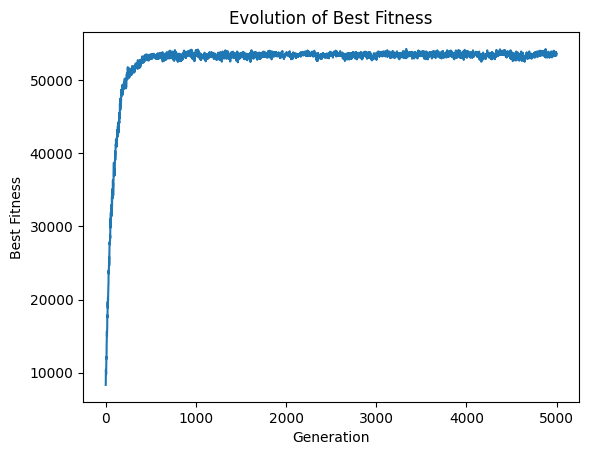

54260


In [1871]:
popsize = 500
generations = 5000
m = 0
best = []
mutation_probablity=1/item_count
population = random_population(popsize, item_count)
for i in range (generations):
    fitness_values = np.apply_along_axis(fitness, axis=1, arr=population)
    new = selection(population, fitness_values)
    population = crossover(new)
    #population = mutation(population,mutation_probablity)
    population = mutation_fast(population,1)
    A =np.matmul(population, data)
    valid_rows = A[A[:, 1] < capacity]
    if valid_rows.shape[0] > 0:
        m = max(m,np.max(valid_rows[:,0]))
        best.append(int(np.max(valid_rows[:,0])))
plt.plot(best)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Evolution of Best Fitness")
plt.savefig("convergence_plot_best1000.png", dpi=300, bbox_inches='tight')
plt.show()
print(max(best))



the same code but for input100.txt

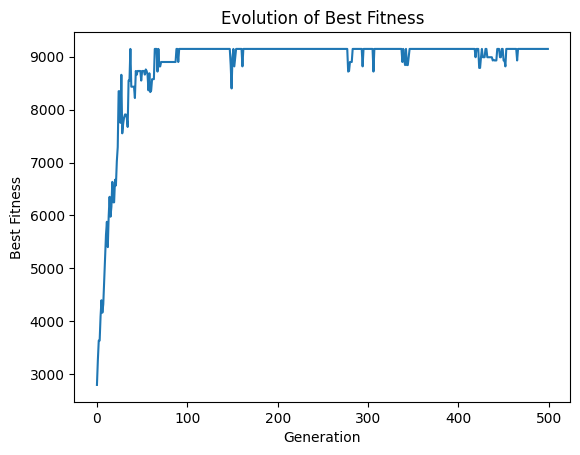

9147


In [1872]:
# loading of the file.
#input data price , weight
file_name = "input_100.txt"

with open(file_name, "r") as file:
    first_line = file.readline().strip()
item_count, capacity = map(int, first_line.split())

data = np.loadtxt(file_name,skiprows=1,dtype=int)
sum_price = np.sum(data[:,0])
sum_weight = np.sum(data[:,1])
average_weight = sum_weight /item_count
amount_of_ones = capacity / average_weight
ones_probability = (amount_of_ones/item_count)*0.90


popsize = 500
generations = 500
m = 0
best = []
mutation_probablity=1/item_count
population = random_population(popsize, item_count)



for i in range (generations):
    fitness_values = np.apply_along_axis(fitness, axis=1, arr=population)
    new = selection(population, fitness_values)
    population = crossover(new)
    #population = mutation(population,mutation_probablity)
    population = mutation_fast(population,1)
    A =np.matmul(population, data)
    valid_rows = A[A[:, 1] < capacity]
    if valid_rows.shape[0] > 0:
        m = max(m,np.max(valid_rows[:,0]))
        best.append(int(np.max(valid_rows[:,0])))
plt.plot(best)
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.title("Evolution of Best Fitness")
plt.savefig("convergence_plot_best1000.png", dpi=300, bbox_inches='tight')
plt.show()
print(max(best))

